Missing compiler_cxx fix for MSVCCompiler
Missing compiler_cxx fix for MSVCCompiler
Spike times: [    4.      4.4     5.  ...,  1999.4  1999.6  1999.9] ms


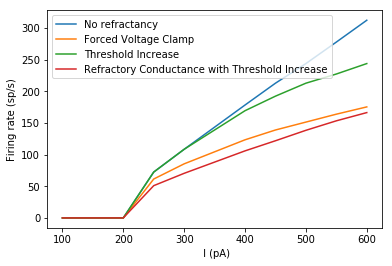

In [33]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# Descrição dos parâmetros do modelo
Cm = 0.1*nfarad # capacitância da membrana
Rm = 100*Mohm # resistência da membrana
El = -70*mV # potencial de equilíbrio da membrana
Vl = -50*mV # valor limiar de tensão de emissão de disparo
vr = -65*mV # valor de tensão de repouso após 'resetagem'
Ek = -80*mV # potencial de equilíbrio da membrana
tau_Gx = 0.2*ms
duration = 2000*ms
delta_Gx = 2*usiemens
vl_0 = -50*mV
tau_vl = 1*ms
vl_reset = 200*mV

start_scope()
G = NeuronGroup(10, model = '''
dv/dt = ((El - v) / (Cm*Rm)) + (Ix/Cm) : volt
Ix : amp
''', threshold='v>Vl', reset= 'v=vr', method='euler', dt= 0.1*ms)

statemon = StateMonitor(G, 'v', record=0) # monitor de potencial
spikemon = SpikeMonitor(G) # monitor de spikes
G.Ix = [100,150,200,250,300,400,450,500,550,600]*pA

K = NeuronGroup(10, model = '''
dv/dt = ((El - v) / (Cm*Rm)) + (Ix/Cm) : volt (unless refractory)
Ix : amp
''', threshold='v>Vl', reset= 'v=vr', method='euler', dt= 0.1*ms, refractory = 'timestep(t-lastspike, dt) <= timestep(2.5*ms, dt)')

statemon = StateMonitor(K, 'v', record=0) # monitor de potencial
spikemon = SpikeMonitor(K) # monitor de spikes
K.Ix = [100,150,200,250,300,400,450,500,550,600]*pA

L = NeuronGroup(10, model='''dv/dt = ((El - v) / (Cm*Rm)) + (Ix/Cm) : volt
dvl/dt = (vl_0 - vl) / tau_vl : volt
Ix : amp''', threshold='v>vl', reset= "v=vr;vl=vl_reset", method='euler', dt= 0.1*ms)

statemon = StateMonitor(L, ["v","vl"], record=True) # monitor de potencial
spikemon = SpikeMonitor(L) # monitor de spikes
L.Ix = [100,150,200,250,300,400,450,500,550,600]*pA
L.vl = vl_0

M = NeuronGroup(10, model='''
dv/dt = ((El - v) / (Cm*Rm)) + ((Gx*(Ek - v)) / (Cm)) + (Ix/Cm) : volt 
dvl/dt = (vl_0 - vl) / tau_vl : volt
dGx/dt = -Gx/ tau_Gx : siemens
Ix :  amp''', threshold="v>vl", reset= "v=vr;vl=vl_reset; Gx=Gx+delta_Gx", method='euler', dt= 0.1*ms)

statemon = StateMonitor(M, ["v","Gx","vl"], record=True) # monitor de potencial
spikemon = SpikeMonitor(M) # monitor de spikes
M.Ix = [100,150,200,250,300,400,450,500,550,600]*pA
M.Gx = 0*usiemens
M.v = El
M.vl = -50*mV

# tempo de simulação
run(duration)

# plotagem
print("Spike times: %s" % spikemon.t[:])
monitorG = SpikeMonitor(G)
monitorK = SpikeMonitor(K)
monitorL = SpikeMonitor(L)
monitorM = SpikeMonitor(M)
run(duration)
plot(G.Ix/pA, monitorG.count / duration, label = "No refractancy")
plot(K.Ix/pA, monitorK.count / duration, label = "Forced Voltage Clamp")
plot(L.Ix/pA, monitorL.count / duration, label = "Threshold Increase")
plot(M.Ix/pA, monitorM.count / duration, label = "Refractory Conductance with Threshold Increase")
xlabel(' I (pA)')
ylabel('Firing rate (sp/s)')
legend()
show()

